In [14]:
#importing require python packages
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import os
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

In [15]:
#reading and displaying dataset values
dataset = pd.read_csv("Dataset/mimic3d.csv")
dataset

,hadm_id,gender,age,LOSdays,admit_type,admit_location,AdmitDiagnosis,insurance,religion,marital_status,...,NumMicroLabs,NumNotes,NumOutput,NumRx,NumProcEvents,NumTransfers,NumChartEvents,ExpiredHospital,TotalNumInteract,LOSgroupNum
0,100001,F,35,6.17,EMERGENCY,CLINIC REFERRAL/PREMATURE,DIABETIC KETOACIDOSIS,Private,PROTESTANT QUAKER,DIVORCED,...,0.65,0.05,5.19,14.91,1.13,0.65,398.70,0,493.89,1
1,100003,M,59,4.04,EMERGENCY,EMERGENCY ROOM ADMIT,UPPER GI BLEED,Private,NOT SPECIFIED,SINGLE,...,1.24,1.59,5.45,7.18,0.99,1.24,373.02,0,465.71,1
2,100006,F,48,12.04,EMERGENCY,EMERGENCY ROOM ADMIT,COPD FLARE,Private,NOT SPECIFIED,SINGLE,...,0.33,0.15,4.15,6.23,0.00,0.33,286.21,0,344.00,3
3,100007,F,73,7.29,EMERGENCY,EMERGENCY ROOM ADMIT,BOWEL OBSTRUCTION,Private,JEWISH,MARRIED,...,0.69,0.17,9.05,11.52,0.00,0.96,526.06,0,603.05,1
4,100009,M,60,4.88,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,CORONARY ARTERY DISEASE,Private,CATHOLIC,MARRIED,...,0.61,0.34,16.19,25.00,2.87,2.05,554.92,0,679.84,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58971,199993,M,60,24.58,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,CORONARY ARTERY DISEASE,Private,CATHOLIC,DIVORCED,...,0.20,0.13,23.11,8.01,0.00,0.08,1315.46,0,1746.31,3
58972,199994,F,58,9.75,EMERGENCY,EMERGENCY ROOM ADMIT,MENTAL STATUS CHANGES,Medicare,CATHOLIC,SINGLE,...,2.26,0.30,7.90,0.00,0.00,0.31,674.05,0,834.98,2
58973,199995,M,23,16.75,EMERGENCY,PHYS REFERRAL/NORMAL DELI,ROOT ABSCESS,Private,PROTESTANT QUAKER,SINGLE,...,0.54,0.10,6.27,5.79,0.00,0.36,207.10,0,261.30,3
58974,199998,M,69,5.88,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,CORONARY ARTERY DISEASE,Medicare,CATHOLIC,MARRIED,...,0.17,0.35,12.24,17.69,0.00,1.02,426.87,0,537.42,1


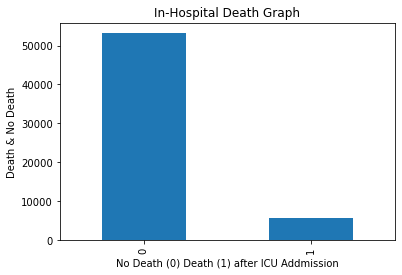

In [16]:
#plotting graph with number of in-hospital death where 0 means no death and 1 means death
savings = dataset.groupby('ExpiredHospital').size()
savings.plot(kind="bar")
plt.xlabel('No Death (0) Death (1) after ICU Addmission')
plt.ylabel('Death & No Death')
plt.title('In-Hospital Death Graph')
plt.show()

In [17]:
#code to extract Y target variable as hospital death and then drop hospital expired and Ham ID
Y = dataset['ExpiredHospital'].ravel()
dataset.drop(['hadm_id', 'ExpiredHospital'], axis = 1,inplace=True)

In [18]:
#code to replace missing values with mean and then convert all non-numeric labels into numeric labels
#and then process dataset
label_encoder = []
columns = dataset.columns
types = dataset.dtypes.values
for i in range(len(types)):
    name = types[i]
    if name == 'object': #finding column with object type
        le = LabelEncoder()
        dataset[columns[i]] = pd.Series(le.fit_transform(dataset[columns[i]].astype(str)))#encode all str columns to numeric 
        label_encoder.append(le)
dataset = dataset.apply(lambda x: x.fillna(x.mean()))#replace all missing values with mean value
#printing dataset after processing
print("Dataset values post processing")
dataset

Dataset values post processing


,gender,age,LOSdays,admit_type,admit_location,AdmitDiagnosis,insurance,religion,marital_status,ethnicity,...,NumLabs,NumMicroLabs,NumNotes,NumOutput,NumRx,NumProcEvents,NumTransfers,NumChartEvents,TotalNumInteract,LOSgroupNum
0,0,35,6.17,1,1,5178,3,16,0,36,...,43.44,0.65,0.05,5.19,14.91,1.13,0.65,398.70,493.89,1
1,1,59,4.04,1,2,15276,3,14,4,36,...,55.94,1.24,1.59,5.45,7.18,0.99,1.24,373.02,465.71,1
2,0,48,12.04,1,2,4336,3,14,4,13,...,33.39,0.33,0.15,4.15,6.23,0.00,0.33,286.21,344.00,3
3,0,73,7.29,1,2,2478,3,10,2,36,...,32.24,0.69,0.17,9.05,11.52,0.00,0.96,526.06,603.05,1
4,1,60,4.88,1,5,4376,3,3,2,36,...,50.61,0.61,0.34,16.19,25.00,2.87,2.05,554.92,679.84,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58971,1,60,24.58,1,5,4376,3,3,0,35,...,66.56,0.20,0.13,23.11,8.01,0.00,0.08,1315.46,1746.31,3
58972,0,58,9.75,1,2,9132,2,3,4,36,...,53.03,2.26,0.30,7.90,0.00,0.00,0.31,674.05,834.98,2
58973,1,23,16.75,1,4,12677,3,16,4,36,...,27.28,0.54,0.10,6.27,5.79,0.00,0.36,207.10,261.30,3
58974,1,69,5.88,1,5,4376,2,3,2,36,...,49.83,0.17,0.35,12.24,17.69,0.00,1.02,426.87,537.42,1


In [19]:
#code to shuffle and normalize X values where X represents all dataset values and Y represents traget values as 0 and 1
#0 means no-death and 1 means death
X = dataset.values
indices = np.arange(X.shape[0])
np.random.shuffle(indices) #shuffle dataset values
X = X[indices]
Y = Y[indices]
scaler = StandardScaler()
X = scaler.fit_transform(X) #normalize values
print("Values after normalization")
X

Values after normalization


array([[-1.12518516,  1.15238328, -0.49734205, ..., -0.56329277,
        -0.53079333, -1.20341029],
       [ 0.88874261,  1.07554266,  0.10798262, ..., -0.15027876,
        -0.18022696,  0.56598776],
       [ 0.88874261,  0.34555674,  1.72004091, ..., -0.2730131 ,
        -0.26107586,  1.45068679],
       ...,
       [ 0.88874261,  0.92186141, -0.69483525, ...,  1.88645834,
         1.86900837, -1.20341029],
       [ 0.88874261,  1.15238328, -0.48048287, ..., -0.12886507,
        -0.1396877 , -0.31871126],
       [ 0.88874261,  0.72975986, -0.56799002, ...,  0.17897038,
         0.10315242, -1.20341029]])

In [7]:
#now split dataset into train and test where 80% dataset used for training and 20% for testing
#split dataset into train and test features
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)
print()
print("Total dataset size : "+str(X.shape[0]))
print("Total features/columns found in dataset : "+str(X.shape[1]))
print("80% training records : "+str(X_train.shape[0]))
print("20% testing records  : "+str(X_test.shape[0]))


Total dataset size : 58976
Total features/columns found in dataset : 26
80% training records : 47180
20% testing records  : 11796


In [8]:
#defining global features to store accuracy and other values
accuracy = []
precision = []
recall = [] 
fscore = []

In [9]:
#function to calculate all metrics
def calculateMetrics(algorithm, testY, predict):
    labels = ['No Death', 'Death']
    p = precision_score(testY, predict,average='macro') * 100
    r = recall_score(testY, predict,average='macro') * 100
    f = f1_score(testY, predict,average='macro') * 100
    a = accuracy_score(testY,predict)*100
    accuracy.append(a)
    precision.append(p)
    recall.append(r)
    fscore.append(f)
    print(algorithm+" Accuracy  : "+str(a))
    print(algorithm+" Precision : "+str(p))
    print(algorithm+" Recall    : "+str(r))
    print(algorithm+" FSCORE    : "+str(f))
    conf_matrix = confusion_matrix(testY, predict)
    fig, axs = plt.subplots(1,2,figsize=(12, 6))
    ax = sns.heatmap(conf_matrix, xticklabels = labels, yticklabels = labels, annot = True, cmap="viridis" ,fmt ="g", ax=axs[0]);
    ax.set_ylim([0,len(labels)])
    axs[0].set_title(algorithm+" Confusion matrix") 

    random_probs = [0 for i in range(len(testY))]
    p_fpr, p_tpr, _ = roc_curve(testY, random_probs, pos_label=1)
    plt.plot(p_fpr, p_tpr, linestyle='--', color='orange',label="True classes")
    ns_fpr, ns_tpr, _ = roc_curve(testY, predict, pos_label=1)
    axs[1].plot(ns_fpr, ns_tpr, linestyle='--', label='Predicted Classes')
    axs[1].set_title(algorithm+" ROC AUC Curve")
    axs[1].set_xlabel('False Positive Rate')
    axs[1].set_ylabel('True Positive rate')
    plt.show()

Random Forest Accuracy  : 94.16751441166498
Random Forest Precision : 90.53922069317727
Random Forest Recall    : 73.76867690002872
Random Forest FSCORE    : 79.43602186829159


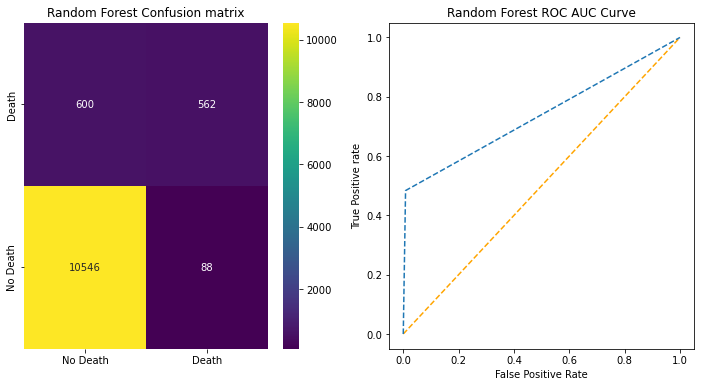

In [10]:
#now train Random Forest algorithm on 80% training data and perform prediction on 20% test data
rf = RandomForestClassifier()
rf.fit(X_train, y_train) #training in train data
predict = rf.predict(X_test) #predicting on test data
calculateMetrics("Random Forest", y_test, predict)

XGBoost Accuracy  : 94.5320447609359
XGBoost Precision : 88.6353213436532
XGBoost Recall    : 77.91857669534636
XGBoost FSCORE    : 82.17900468630232


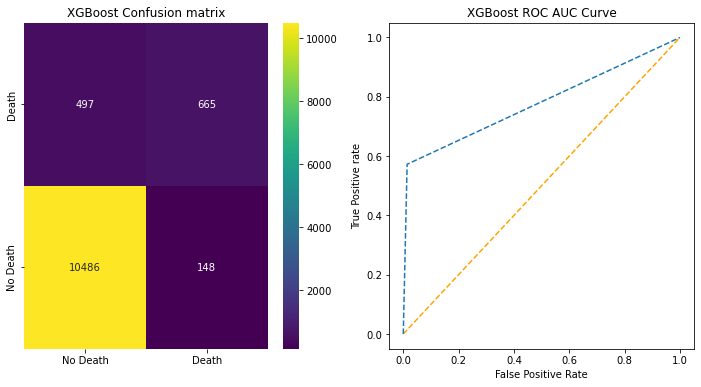

In [11]:
#now train XGBoost algorithm on 80% training data and perform prediction on 20% test data
xg = XGBClassifier()
xg.fit(X_train, y_train)
predict = xg.predict(X_test)
calculateMetrics("XGBoost", y_test, predict)

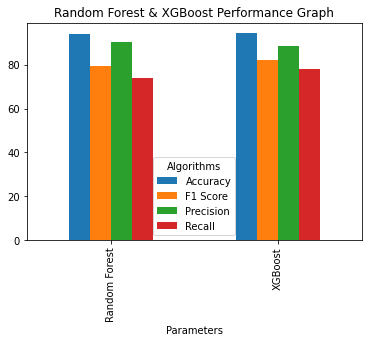

In [12]:
#now plot accuracy and other metrics comparison graph
df = pd.DataFrame([['Random Forest','Precision',precision[0]],['Random Forest','Recall',recall[0]],['Random Forest','F1 Score',fscore[0]],['Random Forest','Accuracy',accuracy[0]],
                   ['XGBoost','Precision',precision[1]],['XGBoost','Recall',recall[1]],['XGBoost','F1 Score',fscore[1]],['XGBoost','Accuracy',accuracy[1]],
                  ],columns=['Parameters','Algorithms','Value'])
df.pivot("Parameters", "Algorithms", "Value").plot(kind='bar')
plt.title("Random Forest & XGBoost Performance Graph")
plt.show()

In [13]:
#Performance of all algorithms in tabular format
columns = ["Algorithm Name","Accuracy", "Precision", "Recall", "FSCORE"]
values = []
algorithm_names = ["Random Forest", "XGBoost"]
for i in range(len(algorithm_names)):
    values.append([algorithm_names[i],accuracy[i],precision[i],recall[i],fscore[i]])
    
temp = pd.DataFrame(values,columns=columns)
temp

,Algorithm Name,Accuracy,Precision,Recall,FSCORE
0,Random Forest,94.167514,90.539221,73.768677,79.436022
1,XGBoost,94.532045,88.635321,77.918577,82.179005


In [36]:
#now predict saving from test data
labels = ['No Death in ICU', 'Death in ICU']
dataset = pd.read_csv("Dataset/testData.csv")#reading test data
column = dataset.columns.ravel()
index = 0
for i in range(len(column)):
    if str(dataset.dtypes[column[i]]) == 'object': #if column is string then encode to number
        dataset[column[i]] = pd.Series(label_encoder[index].fit_transform(dataset[column[i]].astype(str)))
        index = index + 1
dataset = dataset.apply(lambda x: x.fillna(x.mean()))#replace all missing values with mean value
dataset = dataset.values
X = dataset[:,0:dataset.shape[1]]#getting all features from test data and assigning to X
X = scaler.transform(X)
predict = xg.predict(X)#using extension prediction on test data
for i in range(len(predict)):
    print("Test Data = "+str(dataset[i])+" Predicted As ====> "+labels[predict[i]])
    print()

Test Data = [0.00000e+00 6.20000e+01 1.88000e+00 0.00000e+00 2.00000e+00 0.00000e+00
 1.00000e+00 0.00000e+00 0.00000e+00 2.00000e+00 0.00000e+00 5.32000e+00
 1.06000e+00 3.00000e+00 1.60000e+00 9.41500e+01 9.57400e+01 1.60000e+00
 2.55000e+00 1.43600e+01 4.36200e+01 3.72000e+00 1.06000e+00 1.22713e+03
 1.49191e+03 0.00000e+00] Predicted As ====> No Death in ICU

Test Data = [1.0000e+00 4.6000e+01 2.4600e+00 0.0000e+00 1.0000e+00 4.0000e+00
 0.0000e+00 0.0000e+00 1.0000e+00 1.0000e+00 4.1000e-01 4.4700e+00
 1.6300e+00 0.0000e+00 2.0300e+00 1.3410e+01 5.6100e+01 4.1000e-01
 3.8000e+00 1.2200e+01 8.9400e+00 1.6300e+00 1.6300e+00 7.2683e+02
 8.3349e+02 0.0000e+00] Predicted As ====> No Death in ICU

Test Data = [1.00000e+00 5.60000e+01 4.88000e+00 0.00000e+00 1.00000e+00 2.00000e+00
 1.00000e+00 1.00000e+00 1.00000e+00 2.00000e+00 0.00000e+00 3.69000e+00
 1.84000e+00 2.00000e+00 2.05000e+00 2.24800e+02 1.11890e+02 4.51000e+00
 1.01000e+00 4.40600e+01 1.47500e+01 0.00000e+00 4.10000e-01 2.

C:\Users\HP\AppData\Local\Temp\ipykernel_13988\863409527.py:4: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  column = dataset.columns.ravel()
